# Segment documents using (unsupervised) clustering
- We use emails as data

In [1]:
# Installs
# python3 -m pip install Pillow
#! python3 -m pip install matplotlib -U
#! pip install matplotlib==3.1.3

# Full open dataset for Enron emails link

In [2]:
# Download open email dataset from: http://www.cs.cmu.edu/~enron/
#! wget http://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz

# Imports

In [3]:
import yaml
import pandas as pd
import numpy as np

from PIL import Image

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt

%matplotlib inline 

# Load sample data

In [4]:
import yaml

with open('enron_email_sample.yaml') as file:
    email_list = yaml.load(file, Loader=yaml.FullLoader)
    print(email_list['1'])


From: Greg_Hathaway@dom.com [mailto:Greg_Hathaway@dom.com]
Sent: Tuesday, September 18, 2001 10:09 AM
To: Williams, Jo; Miller, Kent; Mercaldo, Vernon
Cc: Gregg_Tyson@dom.com; Hillary_Dryselius@dom.com;
Jason_J_Lewis@dom.com; Stacy_Lee@dom.com; Mark_Moyer@dom.com;
Brent_Cinnamond@dom.com; MLDotter@aol.com; johnwayneking@aol.com; George
Briden; Duane_K._Duclaux@dom.com; Scot_Hathaway@dom.com;
Guy_Chapman@dom.com
Subject: NNG Letter asking for Written Clarifications




Jo, Kent, Vernon:
Good morning!  Hope all is going well in Omaha and Houston.  As we discussed at
lunch in Kansas City we were going to request some information from you in
writing and to that extent please see the attached file.(See attached file:
Northern Letter asking for clarification.doc)



Greg Hathaway
804.273.4421
Virginia Power Energy Marketing (VPEM)
5000 Dominion Blvd.
Glen Allen, Virginia 23060
Innsbrook 3rd Floor



# Choose one doc

In [5]:
email = email_list['3']
print(email)


From: Mercaldo,Vernon<Vernon.Mercaldo@enron.com>
Sent: 11/01/01 12:47 PM
To: Greg Hathaway/WP/VANCPOWER@VANCPOWER
"Blair, Lynn" <Lynn.Blair@enron.com>, "Kowalke, Terry"
<Terry.Kowalke@enron.com>, "Medeles, Gerry"
<Gerry.Medeles@enron.com>, "Williams, Jo" <Jo.Williams@enron.com>,
"Buchanan, John" <John.Buchanan@enron.com>
Subject: Demarc Allocation Conference Cal



Greg,

Looks like 2:00 CST (3:00 EST) on Tuesday, November 6 is good from this
side.  Let me know if this is good from your side and we will schedule
accordingly.

Thanks!
Vernon


**********************************************************************
This e-mail is the property of Enron Corp. and/or its relevant affiliate and may
contain confidential and privileged material for the sole use of the intended
recipient (s). Any review, use, distribution or disclosure by others is strictly
prohibited. If you are not the intended recipient (or authorized to receive for
the recipient), please contact the sender or reply to Enron

# Functions

In [6]:
# clean mails from windows - substitute \r\n to \n 
def clean_doc(doc):
    newdoc = doc.replace("\r\n", "\n")
    return(newdoc)


def generate_doc_for_view(doc):
    # doc to rows
    doc_rows = doc.split("\n")
    doc_structure = []

    for i in range(len(doc_rows)):
        row = doc_rows[i]
        print(i, row)
        doc_structure.append(str(i)+": "+ row)
    return(doc_structure)  


def generate_doc_letter_features(doc):
    doc_rows = doc.split("\n")
    rows_dict = dict()
    doc_letter_features = []
    letter_to_row = dict()
    counter = -1
    for i in range(len(doc_rows)):
        row = doc_rows[i].rstrip()
        rows_dict[i] = len(row)

        for j in range(len(row)):
            counter+=1
            letter_features = (i,j)
            doc_letter_features.append(letter_features)
            letter_to_row[counter] = i
    
    print(len(doc_letter_features))        
    return(doc_letter_features, letter_to_row)    


def view_doc_as_image(X):
    max_rows = X[:,0].max() + 1
    max_columns = X[:,1].max() + 1
    w, h = max_columns, max_rows
    data = np.zeros((h, w, 3), dtype=np.uint8)
    for pix in mail_letter_features:  
        data[pix[0], pix[1]] = [255, 0, 0] # red patch in upper left
    img = Image.fromarray(data, 'RGB')
    #img.save('my.png')
    #img.show()

    fig= plt.figure(figsize=(18,6))
    plt.imshow(data, interpolation='nearest')
    plt.show()
    
def show_doc_with_row_labels(labels, doc_structure):
    labels_with_row = []
    for i in range(labels.shape[0]):
        labels_with_row.append( (labels[i],letter_to_row[i]) ) 
    
    cluster_to_row_array = pd.DataFrame(labels_with_row).drop_duplicates().values
    cluster_to_row_dict = dict()
    for p in cluster_to_row_array:
        cluster_label = p[0]
        row_label = p[1]
        cluster_to_row_dict[row_label] = cluster_label

    for i in range(len(doc_structure)):
        if i in cluster_to_row_dict:
            print(cluster_to_row_dict[i], doc_structure[i])
        else:
            print("-", doc_structure[i])    

# Generate mail data set

In [7]:
remail = clean_doc(email)
remail

'\nFrom: Mercaldo,Vernon<Vernon.Mercaldo@enron.com>\nSent: 11/01/01 12:47 PM\nTo: Greg Hathaway/WP/VANCPOWER@VANCPOWER\n"Blair, Lynn" <Lynn.Blair@enron.com>, "Kowalke, Terry"\n<Terry.Kowalke@enron.com>, "Medeles, Gerry"\n<Gerry.Medeles@enron.com>, "Williams, Jo" <Jo.Williams@enron.com>,\n"Buchanan, John" <John.Buchanan@enron.com>\nSubject: Demarc Allocation Conference Cal\n\n\n\nGreg,\n\nLooks like 2:00 CST (3:00 EST) on Tuesday, November 6 is good from this\nside.  Let me know if this is good from your side and we will schedule\naccordingly.\n\nThanks!\nVernon\n\n\n**********************************************************************\nThis e-mail is the property of Enron Corp. and/or its relevant affiliate and may\ncontain confidential and privileged material for the sole use of the intended\nrecipient (s). Any review, use, distribution or disclosure by others is strictly\nprohibited. If you are not the intended recipient (or authorized to receive for\nthe recipient), please contact 

In [8]:
email_structure = generate_doc_for_view(remail)

0 
1 From: Mercaldo,Vernon<Vernon.Mercaldo@enron.com>
2 Sent: 11/01/01 12:47 PM
3 To: Greg Hathaway/WP/VANCPOWER@VANCPOWER
4 "Blair, Lynn" <Lynn.Blair@enron.com>, "Kowalke, Terry"
5 <Terry.Kowalke@enron.com>, "Medeles, Gerry"
6 <Gerry.Medeles@enron.com>, "Williams, Jo" <Jo.Williams@enron.com>,
7 "Buchanan, John" <John.Buchanan@enron.com>
8 Subject: Demarc Allocation Conference Cal
9 
10 
11 
12 Greg,
13 
14 Looks like 2:00 CST (3:00 EST) on Tuesday, November 6 is good from this
15 side.  Let me know if this is good from your side and we will schedule
16 accordingly.
17 
18 Thanks!
19 Vernon
20 
21 
22 **********************************************************************
23 This e-mail is the property of Enron Corp. and/or its relevant affiliate and may
24 contain confidential and privileged material for the sole use of the intended
25 recipient (s). Any review, use, distribution or disclosure by others is strictly
26 prohibited. If you are not the intended recipient (or authorized to 

In [9]:
mail_letter_features, letter_to_row = generate_doc_letter_features(remail)
mail_letter_features[:10]

1475


[(1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9)]

# Prepare data for clustering

In [10]:
X = np.asarray(mail_letter_features)

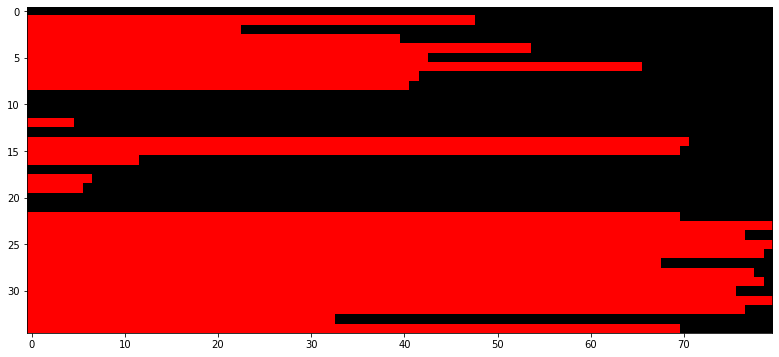

In [11]:
view_doc_as_image(X)

# Clustering

In [13]:
max_rows = X[:,0].max() + 1
max_columns = X[:,1].max() + 1
print(max_rows, max_columns)

35 80


In [14]:
# scaling the column axis
X[:,1] = X[:,1] / max_columns

## Kmeans

In [15]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print(kmeans.cluster_centers_)
labels = kmeans.labels_

[[27.75712777  0.        ]
 [ 4.65826331  0.        ]
 [14.83040936  0.        ]]


In [16]:
show_doc_with_row_labels(labels, email_structure)

- 0: 
1 1: From: Mercaldo,Vernon<Vernon.Mercaldo@enron.com>
1 2: Sent: 11/01/01 12:47 PM
1 3: To: Greg Hathaway/WP/VANCPOWER@VANCPOWER
1 4: "Blair, Lynn" <Lynn.Blair@enron.com>, "Kowalke, Terry"
1 5: <Terry.Kowalke@enron.com>, "Medeles, Gerry"
1 6: <Gerry.Medeles@enron.com>, "Williams, Jo" <Jo.Williams@enron.com>,
1 7: "Buchanan, John" <John.Buchanan@enron.com>
1 8: Subject: Demarc Allocation Conference Cal
- 9: 
- 10: 
- 11: 
2 12: Greg,
- 13: 
2 14: Looks like 2:00 CST (3:00 EST) on Tuesday, November 6 is good from this
2 15: side.  Let me know if this is good from your side and we will schedule
2 16: accordingly.
- 17: 
2 18: Thanks!
2 19: Vernon
- 20: 
- 21: 
0 22: **********************************************************************
0 23: This e-mail is the property of Enron Corp. and/or its relevant affiliate and may
0 24: contain confidential and privileged material for the sole use of the intended
0 25: recipient (s). Any review, use, distribution or disclosure by others is st

## DBSCAN with search on eps

In [17]:
eps_list = {2,3,4}
min_clusters = 3
for current_eps in eps_list:
    db = DBSCAN(eps=current_eps, min_samples=30).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    if n_clusters_ >= min_clusters:
        print("best eps found:", current_eps)
        break

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

best eps found: 2
Estimated number of clusters: 3
Estimated number of noise points: 6


In [18]:
show_doc_with_row_labels(labels, email_structure)        

- 0: 
0 1: From: Mercaldo,Vernon<Vernon.Mercaldo@enron.com>
0 2: Sent: 11/01/01 12:47 PM
0 3: To: Greg Hathaway/WP/VANCPOWER@VANCPOWER
0 4: "Blair, Lynn" <Lynn.Blair@enron.com>, "Kowalke, Terry"
0 5: <Terry.Kowalke@enron.com>, "Medeles, Gerry"
0 6: <Gerry.Medeles@enron.com>, "Williams, Jo" <Jo.Williams@enron.com>,
0 7: "Buchanan, John" <John.Buchanan@enron.com>
0 8: Subject: Demarc Allocation Conference Cal
- 9: 
- 10: 
- 11: 
1 12: Greg,
- 13: 
1 14: Looks like 2:00 CST (3:00 EST) on Tuesday, November 6 is good from this
1 15: side.  Let me know if this is good from your side and we will schedule
1 16: accordingly.
- 17: 
1 18: Thanks!
-1 19: Vernon
- 20: 
- 21: 
2 22: **********************************************************************
2 23: This e-mail is the property of Enron Corp. and/or its relevant affiliate and may
2 24: contain confidential and privileged material for the sole use of the intended
2 25: recipient (s). Any review, use, distribution or disclosure by others is s